## Predicting the Minority Percentage for Public High Schools
**This notebook explores predicting the Minority Percentage for public high schools in North Carolina.** 
* Using **NO** racial composition data, can we predict the minority percentage for a public high school?
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* Since the response variable is highly unbalanced we choose to set the *class_weight* parameter to 'balanced.  While this lowers overall accuracy, it almost doubles recall which is the model's ability to accurately identify highly segeregated schools.   

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2014/Machine Learning Datasets/PublicMiddleSchools2014_ML.csv"
schData=pd.read_csv(path, low_memory=False)

#inspect data 
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Columns: 355 entries, student_num to unit_code
dtypes: float64(313), int64(42)
memory usage: 1.5 MB


In [2]:
#The MinorityPct field was removed from the _ML dataset for being highly correlated with other racial composition fields
#We will merge it back in to the _ML dataset, since this is our response variable. 
path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2014/School Datasets/PublicMiddleSchools2014.csv"
responseData=pd.read_csv(path, low_memory=False)

responseData = responseData[['unit_code','MinorityPct']]

#inspect data 
responseData.info(verbose=False)



#Merge the response variable into our _ML data (schData)
schData = schData.merge(responseData,how='left',on='unit_code', suffixes=('', '_Drop'))

print('*********************************After: MinorityPct Added***********************')
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Columns: 2 entries, unit_code to MinorityPct
dtypes: float64(1), int64(1)
memory usage: 8.5 KB
*********************************After: MinorityPct Added***********************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Columns: 356 entries, student_num to MinorityPct
dtypes: float64(314), int64(42)
memory usage: 1.5 MB


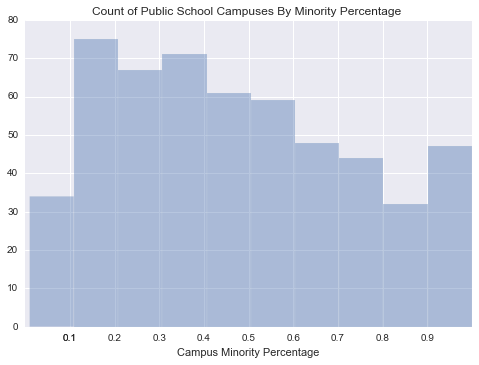

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schData['MinorityPct'], kde=False)
hst.set_xlabel("Campus Minority Percentage")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10])
_ = plt.title('Count of Public School Campuses By Minority Percentage ')

In [4]:
#Delete all racial composition data from our dataset. 
raceCompositionFields = ['Indian Male','Asian Male','Hispanic Male','Black Male','White Male'
                         ,'Pacific Island Male','Pacific Island Female','Two or  More Male','Two or  More Female'
                         ,'Pacific Island','Majority_Minority','White_Pct','Two or More']

RaceCols = schData.columns[(schData.columns.str.lower().str.contains('indian')) | 
                           (schData.columns.str.lower().str.contains('asian')) |
                           (schData.columns.str.lower().str.contains('hispanic')) |
                           (schData.columns.str.lower().str.contains('black')) |
                           (schData.columns.str.lower().str.contains('white')) |
                           (schData.columns.str.lower().str.contains('pacific island')) |
                           (schData.columns.str.lower().str.contains('two or  more')) |
                           (schData.columns.str.lower().str.contains('minority'))]
RaceCols

Index([u'EOCMathI_CACR_AmericanIndian', u'EOCSubjects_CACR_AmericanIndian',
       u'EOG/EOCSubjects_CACR_AmericanIndian', u'EOGGr6_CACR_AmericanIndian',
       u'EOGGr7_CACR_AmericanIndian', u'EOGGr8_CACR_AmericanIndian',
       u'EOGMathGr3-8_CACR_AmericanIndian', u'EOGMathGr6_CACR_AmericanIndian',
       u'EOGMathGr7_CACR_AmericanIndian', u'EOGMathGr7_GLP_AmericanIndian',
       u'EOGMathGr8_CACR_AmericanIndian', u'EOGMathGr8_GLP_AmericanIndian',
       u'EOGReadingGr3-8_CACR_AmericanIndian',
       u'EOGReadingGr6_CACR_AmericanIndian',
       u'EOGReadingGr6_GLP_AmericanIndian',
       u'EOGReadingGr7_CACR_AmericanIndian',
       u'EOGReadingGr8_CACR_AmericanIndian',
       u'EOGReadingGr8_GLP_AmericanIndian',
       u'EOGScienceGr5&8_CACR_AmericanIndian', u'EOCMathI_CACR_Asian',
       u'EOG/EOCSubjects_CACR_Asian', u'EOGGr6_CACR_Asian',
       u'EOGGr7_CACR_Asian', u'EOGGr8_CACR_Asian', u'EOGMathGr3-8_CACR_Asian',
       u'EOGMathGr6_CACR_Asian', u'EOGMathGr7_CACR_Asian',
       

In [5]:
# create x explanatory and y response variables for regression
Y_MinorityPct = schData['MinorityPct'] 
Y = Y_MinorityPct

#Delete all racial composition data from our dataset.
X_highSchools = schData.drop(RaceCols, axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538 entries, 0 to 537
Columns: 260 entries, student_num to unit_code
dtypes: float64(218), int64(42)
memory usage: 1.1 MB


In [6]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [7]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Classifier Evaluation
** The following function performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, and recall.** 

In [8]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print classReport
    print confMat
    print acc

## Minority Percent - Logistic Regression 
**This model uses a Logistic Regression to classify public high schools as greater than 40% to 90% minorities. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [9]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   16.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [10]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [11]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.40

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.83519
The average precision for all cv folds is: 			 0.87298
The average recall for all cv folds is: 			 0.82566
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.833333,0.923077,0.774194
1,0.796296,0.933333,0.756757
2,0.814815,0.833333,0.833333
3,0.851852,0.909091,0.857143
4,0.814815,0.833333,0.833333
5,0.870370,0.896552,0.866667
6,0.814815,0.869565,0.740741
7,0.851852,0.848485,0.903226
8,0.833333,0.760000,0.863636
9,0.870370,0.923077,0.827586


In [12]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.50

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.85741
The average precision for all cv folds is: 			 0.83984
The average recall for all cv folds is: 			 0.84609
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.870370,0.925926,0.833333
1,0.833333,0.892857,0.806452
2,0.870370,0.846154,0.880000
3,0.833333,0.862069,0.833333
4,0.870370,0.807692,0.913043
5,0.851852,0.840000,0.840000
6,0.759259,0.684211,0.650000
7,0.870370,0.793103,0.958333
8,0.888889,0.833333,0.833333
9,0.925926,0.913043,0.913043


In [13]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.86      0.83      0.85       303
       True       0.79      0.83      0.81       235

avg / total       0.83      0.83      0.83       538

[[252  51]
 [ 41 194]]
0.828996282527881


In [14]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.60

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.87593
The average precision for all cv folds is: 			 0.79729
The average recall for all cv folds is: 			 0.86468
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.907407,0.947368,0.818182
1,0.777778,0.761905,0.695652
2,0.870370,0.727273,0.941176
3,0.851852,0.869565,0.800000
4,0.888889,0.809524,0.894737
5,0.907407,0.789474,0.937500
6,0.870370,0.647059,0.916667
7,0.870370,0.818182,0.857143
8,0.907407,0.769231,0.833333
9,0.907407,0.833333,0.952381


In [15]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.91      0.84      0.87       365
       True       0.71      0.82      0.76       173

avg / total       0.84      0.83      0.84       538

[[307  58]
 [ 32 141]]
0.8327137546468402


**The next model uses a Logistic Regression to classify public high schools as greater than 90% minority**

In [16]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.70

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.86111
The average precision for all cv folds is: 			 0.66382
The average recall for all cv folds is: 			 0.88563
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.833333,0.625000,0.769231
1,0.777778,0.545455,0.857143
2,0.907407,0.750000,0.923077
3,0.851852,0.736842,0.823529
4,0.833333,0.650000,0.866667
5,0.888889,0.666667,1.000000
6,0.907407,0.615385,1.000000
7,0.907407,0.812500,0.866667
8,0.925926,0.636364,1.000000
9,0.777778,0.600000,0.750000


In [17]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.93      0.83      0.88       414
       True       0.58      0.79      0.67       124

avg / total       0.85      0.82      0.83       538

[[344  70]
 [ 26  98]]
0.8215613382899628


In [18]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.86667
The average precision for all cv folds is: 			 0.56526
The average recall for all cv folds is: 			 0.81113
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.851852,0.461538,0.857143
1,0.796296,0.500000,0.545455
2,0.944444,0.900000,0.818182
3,0.814815,0.400000,0.857143
4,0.870370,0.666667,0.833333
5,0.907407,0.692308,0.900000
6,0.888889,0.500000,1.000000
7,0.870370,0.615385,0.800000
8,0.944444,0.666667,1.000000
9,0.777778,0.250000,0.500000


In [19]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.95      0.86      0.91       458
       True       0.49      0.75      0.59        80

avg / total       0.88      0.85      0.86       538

[[396  62]
 [ 20  60]]
0.8475836431226765


In [20]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.90

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.91481
The average precision for all cv folds is: 			 0.50671
The average recall for all cv folds is: 			 0.84655
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.870370,0.375000,0.600000
1,0.944444,0.666667,1.000000
2,0.925926,0.666667,0.857143
3,0.907407,0.444444,1.000000
4,0.925926,0.700000,0.875000
5,0.925926,0.600000,1.000000
6,0.925926,0.400000,0.666667
7,0.907407,0.500000,0.800000
8,0.925926,0.428571,1.000000
9,0.888889,0.285714,0.666667


In [21]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.97      0.91      0.94       491
       True       0.42      0.72      0.54        47

avg / total       0.92      0.89      0.90       538

[[445  46]
 [ 13  34]]
0.8903345724907064


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.
* We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately. 
* The scaled data makes more accurate predictions in many cases but not always!

In [24]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

**In this case, I tested scaling the data before cross validation as well.**

In [25]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.9

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    7.1s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [26]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [27]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.8963
The average precision for all cv folds is: 			 0.4527
The average recall for all cv folds is: 			 0.8681
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.907407,0.500000,1.000000
1,0.888889,0.500000,0.833333
2,0.888889,0.555556,0.714286
3,0.925926,0.500000,1.000000
4,0.888889,0.571429,1.000000
5,0.870370,0.461538,1.000000
6,0.888889,0.285714,0.666667
7,0.888889,0.444444,0.800000
8,0.907407,0.375000,1.000000
9,0.907407,0.333333,0.666667


In [28]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

      False       0.98      0.88      0.93       491
       True       0.40      0.85      0.55        47

avg / total       0.93      0.88      0.90       538

[[432  59]
 [  7  40]]
0.8773234200743495


In [29]:
Y.value_counts()

False    491
True      47
Name: MinorityPct, dtype: int64

## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The top performing model predicts the minority percentage of public high schools with 95% accuracy.
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [30]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [31]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

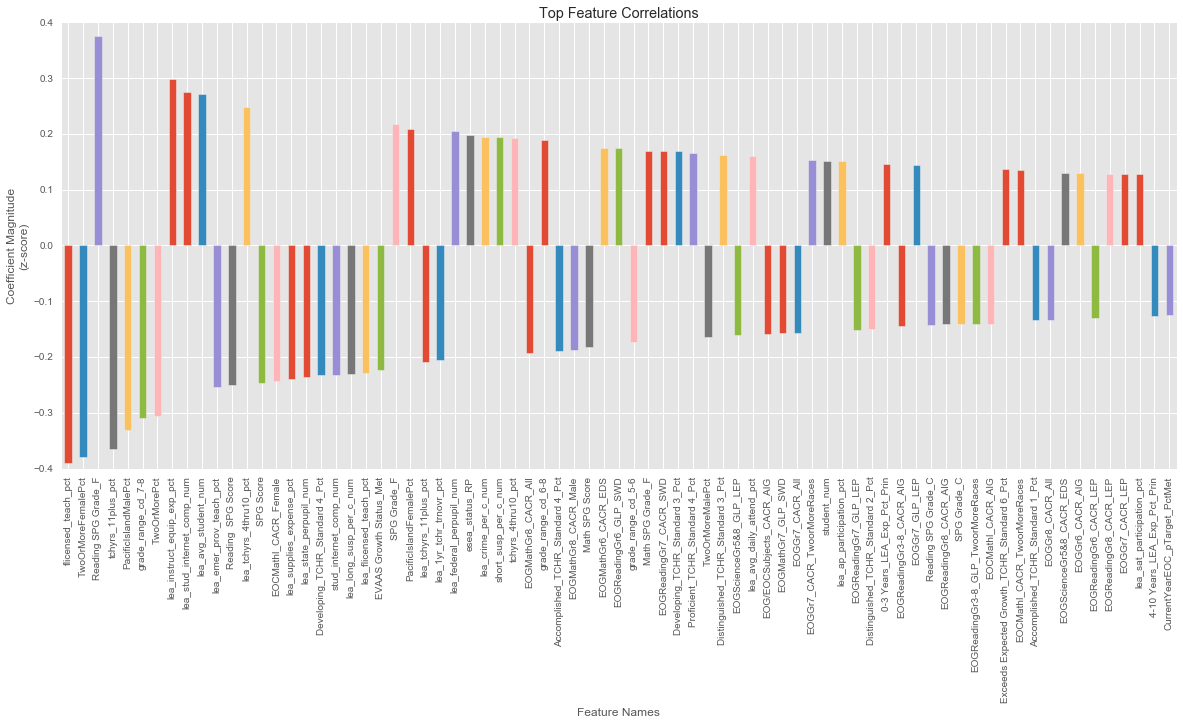

In [32]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Feature Importance Using Recursive Feature Elimination
**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [33]:
#Convert Y to the top performing binary response 
Y = Y_MinorityPct >= 0.9

In [34]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
   estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 208


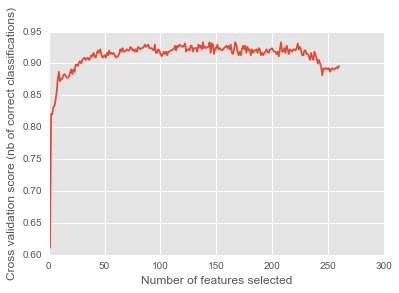

In [35]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [36]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
143,lea_sat_participation_pct,0.933333
207,Proficient_TCHR_Standard 1_Pct,0.933333
137,CurrentYearEOC_pTarget_PctMet,0.933333
166,lateral_teach_pct,0.933333
145,lea_ap_pct_3_or_above,0.931481
121,EOGScienceGr8_GLP_SWD,0.931481
222,grade_range_cd_6-12,0.931481
150,stud_internet_comp_num,0.929630
116,EOGReadingGr8_CACR_SWD,0.929630
162,tchyrs_11plus_pct,0.929630
